In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/ASUS/Desktop/dataANALYSIS'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",username="root",password="root", database="ecommerce")
cur= db.cursor()

# List all unique cities where customers are located. 


In [57]:
query=""" select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
s=pd.Series(data)
s

0                      (franca,)
1       (sao bernardo do campo,)
2                   (sao paulo,)
3             (mogi das cruzes,)
4                    (campinas,)
                  ...           
4114                   (siriji,)
4115      (natividade da serra,)
4116             (monte bonito,)
4117               (sao rafael,)
4118        (eugenio de castro,)
Length: 4119, dtype: object

# Count the number of orders placed in 2017.

In [29]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017;"""
cur.execute(query)
data = cur.fetchall()

"Total orders placed in 2017 are ", data[0][0]

('Total orders placed in 2017 are ', 45101)

# Find the total sales per category.

In [56]:
query="""  select Upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id=order_items.product_id 
join payments 
on payments.order_id=order_items.order_id
group by category 
"""
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=['Category','Sales'])
df.head()

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# Calculate the percentage of orders that were paid in installments.

In [46]:
query = """ select sum((case when payment_installments>=1 then 1
else 0 end))/count(*) * 100 from payments """
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

# Count the number of customers from each state. 

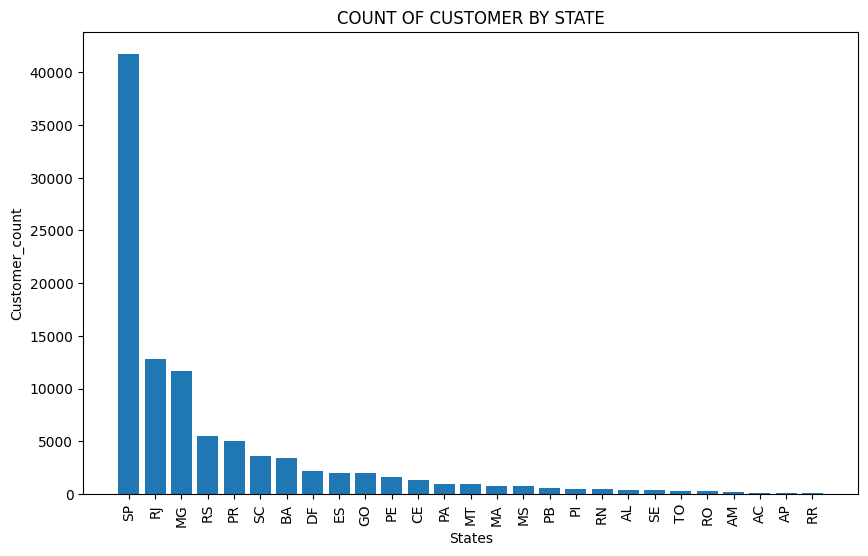

In [24]:
query = """ select c.customer_state, count(c.customer_id) from customers c group by c.customer_state"""
cur.execute(query)
data = cur.fetchall()
df2=pd.DataFrame(data, columns=['State','Count'])
df2 = df2.sort_values(by = "Count" , ascending=False)
plt.figure(figsize=(10,6))
plt.bar(df2['State'],df2['Count'])
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Customer_count')
plt.title('COUNT OF CUSTOMER BY STATE')
plt.show()

 # Calculate the number of orders per month in 2018.

In [8]:
query = """
select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018 
group by months
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['months','order_count'])
df

,months,order_count
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


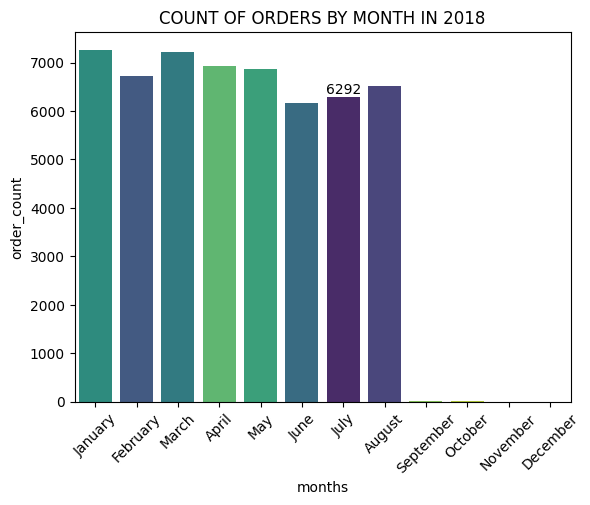

In [35]:
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax= sns.barplot(x = df['months'], y = df['order_count'], data = df, order = o , hue = df['months'] , legend = False ,palette = 'viridis')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title('COUNT OF ORDERS BY MONTH IN 2018')
plt.show()

# Find the average number of products per order, grouped by customer city.

In [39]:
query = """
with count_per_order as (select o.order_id,o.customer_id , count(oi.order_id) as oc
from orders o  join order_items oi on o.order_id=oi.order_id 
group by o.order_id,o.customer_id)
select customers.customer_city , round(avg(count_per_order.oc),2) from customers join 
count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['city','avg_order'])
df.head()

,city,avg_order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# Calculate the percentage of total revenue contributed by each product category.

In [41]:
query = """
select p.product_category Category , round(100 * ( sum(pay.payment_value)/ (select sum(payment_value) from payments) ),2)
Total_Revenue from
products p join order_items o on p.product_id = o.product_id
join payments pay on o.order_id = pay.order_id group by p.product_category;
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['Category','% of Total_revenue'])
df.head()

,Category,% of Total_revenue
0,perfumery,3.17
1,Furniture Decoration,8.93
2,telephony,3.04
3,bed table bath,10.70
4,automotive,5.32


# Identify the correlation between product price and the number of times a product has been purchased.

In [7]:
query = """
select p.product_category, count(o.product_id) , round(avg(o.price),2) from products p join order_items o 
on p.product_id = o.product_id group by p.product_category 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Number of orders", "Average price"])
arr1 = df["Number of orders"]
arr2 = df["Average price"]
a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", a[0][1]) 

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


This means, theere is no correlation between the product price adn number of time it is purchased. Since the value is -0.1 which is very close to neutral.

# Calculate the total revenue generated by each seller, and rank them by revenue

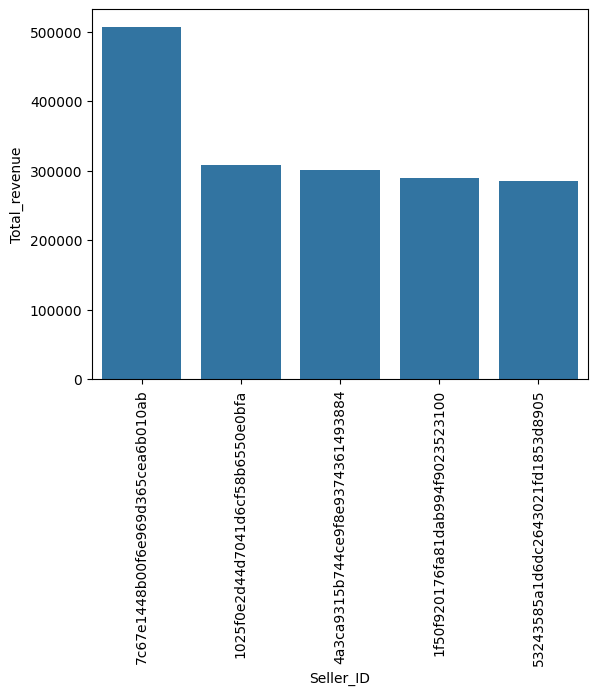

In [15]:
query = """
select *, dense_rank() over(order by Total_Revenue desc) as rn from
(select sellers.seller_id, round(sum(payments.payment_value),2) Total_Revenue from sellers join order_items
on sellers.seller_id = order_items.seller_id join payments on payments.order_id = order_items.order_id
group by sellers.seller_id) as a;
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['Seller_ID','Total_revenue','Rank'])
df = df.head()
sns.barplot(x = df['Seller_ID'], y = df['Total_revenue'] , data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [20]:
query = """
select customer_id,order_purchase_timestamp, avg(Payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id,orders.order_purchase_timestamp, payments.payment_value Payment from orders join payments 
on orders.order_id = payments.order_id) as a ;
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['Customer_id','Order_purchase_timestamp','Moving avg'])
df.head()

,Customer_id,Order_purchase_timestamp,Moving avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002


# Calculate the cumulative sales per month for each year

In [21]:
query ="""
select Year,Month,Payment,sum(Payment) over (order by Year,Month) as cumulative_sum from
(select year(orders.order_purchase_timestamp) Year, month(orders.order_purchase_timestamp) Month,
round(sum(payments.payment_value),2) Payment from orders join payments on orders.order_id = payments.order_id
group by Year,Month order by Year,Month) as a
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['Year','Month','Payment','Cumulative_Sum'])
df.head()

,Year,Month,Payment,Cumulative_Sum
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales

In [22]:
query = """
with a as (select year(orders.order_purchase_timestamp) Year, 
round(sum(payments.payment_value),2) payment 
from orders join payments on orders.order_id = payments.order_id
group by Year order by Year)
select Year, ((payment - lag(payment,1) over (order by Year)) / lag(payment,1) over (order by Year))*100 from a 
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ['Year','yoy % growth'])
df.head()

,Year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [23]:
query="""
with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;
"""
cur.execute(query)
data = cur.fetchall()
data

[(None,)]

In [ ]:
Since there is no customer that buys another product within 6 month interval, therefore the answer is None.

# Identify the top 3 customers who spent the most money in each year.

In [26]:
query="""
select Year,Customer_id, d_rank from 
(select year(orders.order_purchase_timestamp) Year,orders.customer_id Customer_id, sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value)
 desc) d_rank from
orders join payments on orders.order_id = payments.order_id group by Year,orders.customer_id) as a 
where d_rank<=3;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year','Customer_Id','Rank'])
df

,Year,Customer_Id,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,2
2,2016,4a06381959b6670756de02e07b83815f,3
3,2017,1617b1357756262bfa56ab541c47bc16,1
4,2017,c6e2731c5b391845f6800c97401a43a9,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,3
6,2018,ec5b2ba62e574342386871631fafd3fc,1
7,2018,f48d464a0baaea338cb25f816991ab1f,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,3
